# Introduction to the 3S-GEOPROF-COMB pre-release
Globally-gridded (3S) GEOmetrical PROFiles of hydrometeors COMBined radar+lidar dataset. This notebook is a brief introduction to the product and gives some plotting examples. 

Let's load in a granule:

In [1]:
import matplotlib.pyplot as plt   # for plotting
import numpy as np                # for arrays+math
import xarray as xr               # for netCDF data

import cartopy.crs as ccrs        # import projections
import cartopy.feature as cf      # import features

In [2]:
ds=xr.open_dataset("~/Downloads/radarlidar_seasonal_10.0x10.0/2007-DJF_CSCAL_3S-GEOPROF-COMB_10.0x10.0_v8.2_beta.nc")
ds

<xarray.Dataset>
Dimensions:                                 (lat: 18, lon: 36, height: 78, doop: 2, type: 8, height_min: 78, height_max: 78)
Coordinates:
    time                                    datetime64[ns] ...
  * lat                                     (lat) float64 -85.0 -75.0 ... 85.0
  * lon                                     (lon) float64 -175.0 ... 175.0
  * height                                  (height) float64 1.799e+04 ... -4...
  * doop                                    (doop) |S16 b'DO-OP observable' b...
  * type                                    (type) object 'any' ... 'uniquelow'
  * height_min                              (height_min) float64 1.787e+04 .....
  * height_max                              (height_max) float64 1.811e+04 .....
Data variables: (12/15)
    cloud_counts_on_levels                  (doop, lat, lon, height) int64 ...
    total_counts_on_levels                  (doop, lat, lon, height) int64 ...
    cloud_counts_in_column                  (type, doop, lat, lon) int64 ...
    total_counts_in_column                  (type, doop, lat, lon) int64 ...
    attenuated_lidar_counts_on_levels       (doop, lat, lon, height) int64 ...
    attenuated_lidar_counts_in_column       (doop, lat, lon) int64 ...
    ...                                      ...
    localhour22                             (doop, lat, lon) int64 ...
    localhour04                             (doop, lat, lon) int64 ...
    localhour10                             (doop, lat, lon) int64 ...
    localhour16                             (doop, lat, lon) int64 ...
    cloud_fraction_on_levels                (doop, lat, lon, height) float64 ...
    cloud_cover_in_column                   (type, doop, lat, lon) float64 ...
Attributes:
    date_created:          2023-06-19 19:30:42 MST
    from_script:           file created by script 9-3-4_process_seasonal_ncs.py
    from_command:          ../9-3-4_process_seasonal_ncs.py monthsall_v8.2-g10
    author:                William J Bertrand
    num_granules:          1131
    max_num_granules:      1309
    keep_type:             calculated only from granules for which both radar...
    instrument_type:       calculated from merged CloudSat and CALIPSO hydrom...
    resolution_lon (deg):  10.0
    resolution_lat (deg):  10.0
    time_range:            2007-12-01 - 2008-02-29

Hydrometeor variables fall into two types:
1. cloud cover variables showing how many profiles satisfy a certain criterion (any clouds, high clouds, etc.) -- these end with `_in_column`, and
2. vertical cloud fraction variables showing how frequently a vertical level contains cloud -- these end with `_on_levels`.

For both of these categories, the product reports the number of observations with clouds (`cloud_counts_...`), the total number of observations (`total_counts_...`), and the frequency of occurrence (`cloud_cover_...` or `cloud_fraction...`). The frequency is simply the ratio of the cloud counts to the total counts.

Let's check this with total cloud cover (how frequently any cloud is present in the profile):

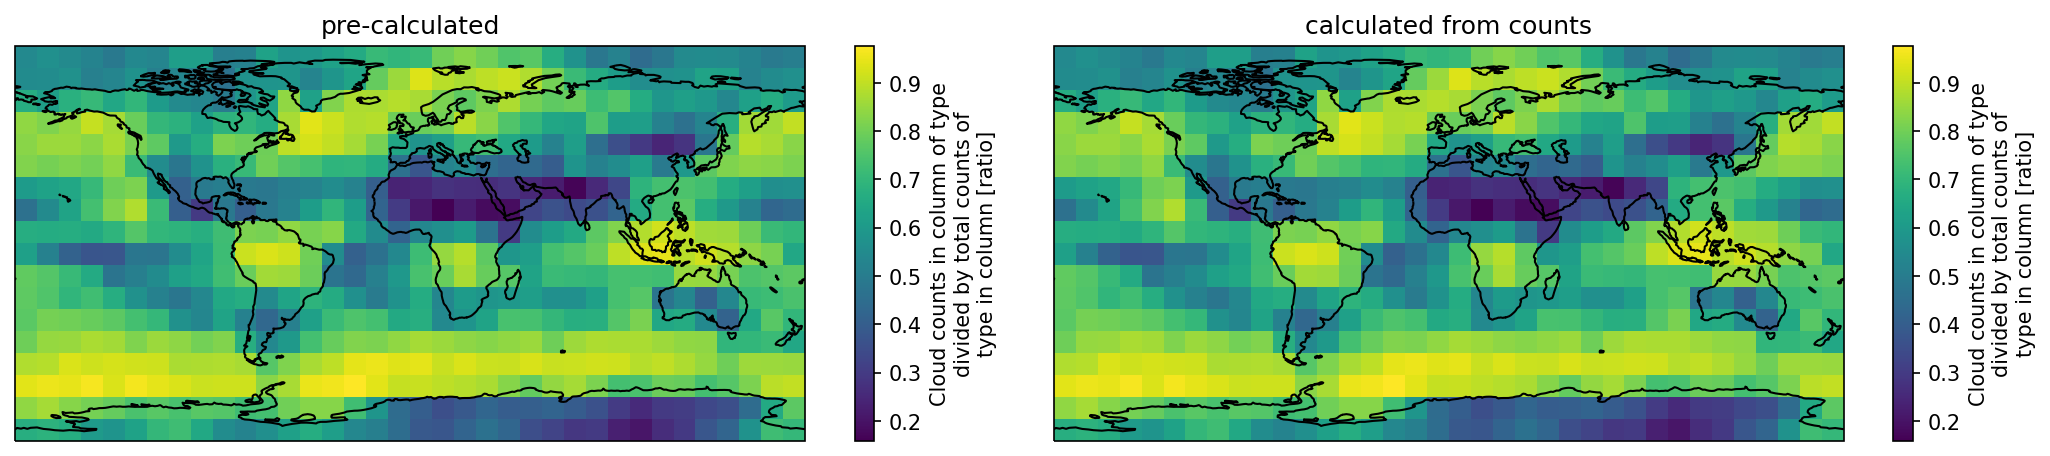

In [3]:
cloud_type='any' #options are in ds.type
doop_mode=b'All cases' #sampling mode, explained later

plt.figure(figsize=(14,3),dpi=150)

#pre-calculated cloud cover
plt.subplot(121,projection=ccrs.PlateCarree()) 
ds.cloud_cover_in_column.sel(doop=doop_mode).sel(type=cloud_type).plot() #select a sampling mode and cloud type
plt.gca().coastlines()
plt.title('pre-calculated')

#cloud cover calculated from counts
plt.subplot(122,projection=ccrs.PlateCarree())
cloud_cover = ds.cloud_counts_in_column/ds.total_counts_in_column #cloud cover = cloud counts / total counts
ds.cloud_cover_in_column.sel(doop=doop_mode).sel(type=cloud_type).plot() #same as above
plt.gca().coastlines()
plt.title('calculated from counts')

plt.tight_layout()

And the results are the same. This is useful if you want to redefine cloud frequency, re-grid the data, or aggregate in some way -- if the process is applied separately to `cloud_counts` and `total_counts` rather than frequency, then we won't accidentally be applying any weighting to our data. Let's check this with cloud cover:

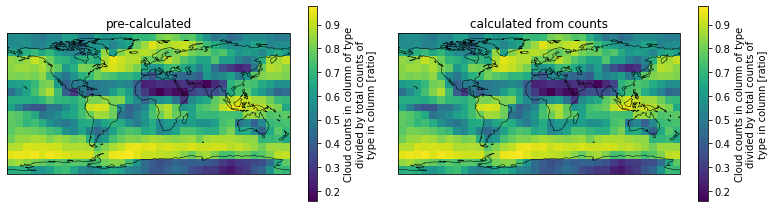

In [4]:
cloud_type='any' #options are in ds.type
doop_mode=b'All cases' #sampling mode, explained later

#make two subplots using a PlateCarree projection
fig,axes = plt.subplots(1,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,3),edgecolor='k')

#pre-calculated cloud cover
ds.cloud_cover_in_column.sel(doop=doop_mode).sel(type=cloud_type).plot(ax=axes[0]) #select a sampling mode and cloud type, plot on the first subplot
axes[0].set_title('pre-calculated')
axes[0].add_feature(cf.COASTLINE,lw=0.5) #add coastlines to the first subplot

#cloud cover calculated from counts
cloud_cover = ds.cloud_counts_in_column/ds.total_counts_in_column #cloud cover = cloud counts / total counts
ds.cloud_cover_in_column.sel(doop=doop_mode).sel(type=cloud_type).plot(ax=axes[1]) #same as above, but plot on the second subplot
axes[1].set_title('calculated from counts')
axes[1].add_feature(cf.COASTLINE,lw=0.5) #add coastlines to the second subplot

fig.tight_layout() #reduce blank space and overlapping plot elements

In the plotting example, we also needed to select a coordinate on the `doop` dimension, which selects our sampling mode. The options are using all data ('All cases') or using Daylight-Only Operations (DO-OP) mode subsampling ('DO-OP observable'), which is when CloudSat transitioned to only operating in the sunlit portion of its orbit in November 2011. For the pre-DO-OP data (June 2006 to April 2011), the 'DO-OP Observable' field gives the total observations subsampled to only what would have been observed in DO-OP mode. This way users can applying a consistent sampling methodology to the entire dataset or see how the DO-OP subsampling affects their analysis by comparing to all observations.

Here's an example of how DO-OP mode might affect zonal-mean vertical cloud fraction:

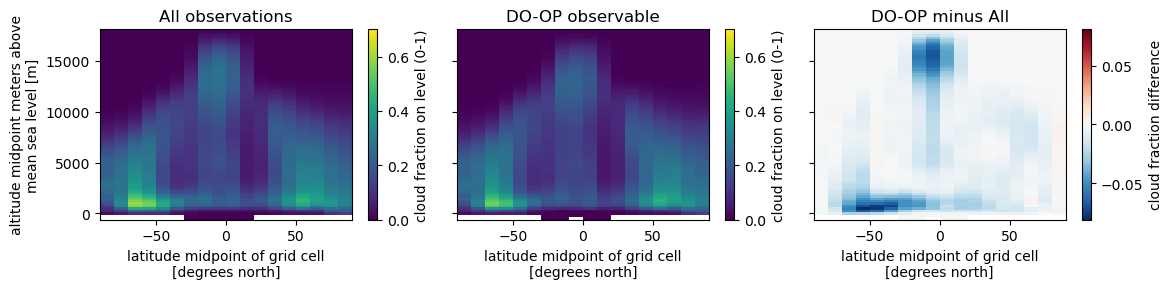

In [5]:
#get data to plot
zonal_mean = ds.cloud_fraction_on_levels.mean(dim='lon').T #take the zonal-mean
da_all     = zonal_mean.sel(doop=b'All cases') #keep all data
da_doop    = zonal_mean.sel(doop=b'DO-OP observable') #subsample data

#make figure
fig,axes = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True,dpi=100)

#all observations
plt.subplot(131) 
da_all.plot(ax=axes[0],cbar_kwargs={'label':'cloud fraction on level (0-1)'},vmin=0,vmax=0.7)
plt.title('All observations')


#DO-OP subsampled data
plt.subplot(132)
da_doop.plot(ax=axes[1],cbar_kwargs={'label':'cloud fraction on level (0-1)'},vmin=0,vmax=0.7)
plt.title('DO-OP observable')
plt.ylabel('')

#effect of DO-OP
plt.subplot(133)
(da_doop-da_all).plot(ax=axes[2],cbar_kwargs={'label':'cloud fraction difference'},cmap='RdBu_r') #same as above
plt.title('DO-OP minus All')
plt.ylabel('')

plt.tight_layout()

This type of analysis is important to get a rough idea of how the data excluded by DO-OP mode might affect your results.

The data product also includes a number of sampling variables -- the most important of which is the number of unique overpasses of a grid cell (`n_overpasses`), but also the number of days observed and the approximate local time of observations. 

Let's check how DO-OP mode affects the local time at which data is collected:

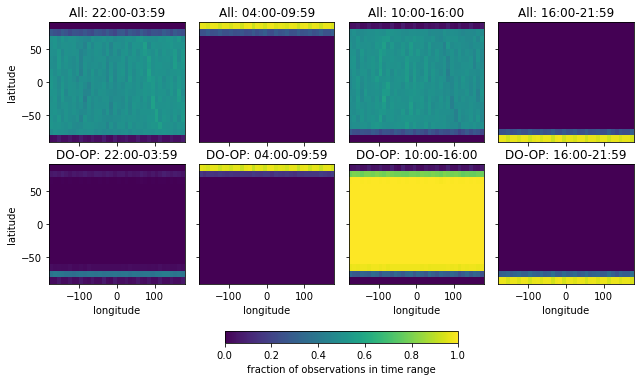

In [6]:
#time variable names
times = ['localhour22','localhour04','localhour10','localhour16']

#dictionary showing the time range of each of the variables
time_ranges = {'localhour22':'22:00-03:59',
               'localhour04':'04:00-09:59',
               'localhour10':'10:00-16:00',
               'localhour16':'16:00-21:59'}

#doop states
doops = [b'All cases',b'DO-OP observable']

#total number of profiles
total_counts = ds.total_counts_in_column.sel(type='any')

#build dictionary showing frequency of each time range 
time_fractions = { }
for time in times:
    time_fractions[time] = ds[time]/total_counts #fraction of observations in time range

#make the figure
fig,axes = plt.subplots(2,4,figsize=(9,6),sharex=True,sharey=True)

#each row is a DO-OP state, each column in a time range
for row,doop in zip(axes,doops):
    for ax,time in zip(row,times):
        #plot the data
        im = time_fractions[time].sel(doop=doop).plot(ax=ax,vmin=0,vmax=1,add_colorbar=False)
        
        #set the title showing the sampling mode and time range
        ax.set_title(f"{str(doop).split(' ')[0][2:]}: {time_ranges[time]}")
        
        #only put ylabels on the first column and xlabels on the bottom row
        ax.set_ylabel('latitude' if ax in axes[:,0] else '')
        ax.set_xlabel('longitude' if ax in axes[-1,:] else '')

#add the colorbar
fig.tight_layout()
fig.colorbar(im, ax=axes[:,:], shrink=0.4,location='bottom',pad=0.13,label='fraction of observations in time range')

Aside from the extreme polarward latitudes, the observations are either at 01:30 (descending branch of the orbit) or 13:30 (ascending branch of the orbit) local time. For some months, DO-OP mode preserves the night-time data for some northern hemisphere latitudes, but for this period the midlatitudes and southern hemisphere are almost exclusively daytime data.